In [0]:
%matplotlib inline

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import PIL
from torch.utils.data.sampler import SubsetRandomSampler
import scipy.io

plt.ion()   # interactive mode

In [0]:
def find_mean_std(train_mat, test_mat):
    h = []
    w = []
    d = []
    for i in range(len(train_mat['X'])):    
        for k in range(32):
            for m in range(32):
                h.append(train_mat['X'][:,:,:,i][k][m][0])
                w.append(train_mat['X'][:,:,:,i][k][m][1])
                d.append(train_mat['X'][:,:,:,i][k][m][2])
    for i in range(len(test_mat['X'])):    
        for k in range(32):
            for m in range(32):
                h.append(test_mat['X'][:,:,:,i][k][m][0])
                w.append(test_mat['X'][:,:,:,i][k][m][1])
                d.append(test_mat['X'][:,:,:,i][k][m][2])
    h, w, d =np.array(h), np.array(w), np.array(d)
    means = [h.mean()/256, w.mean()/256, d.mean()/256]
    stds = [h.std()/256, w.std()/256, d.std()/256]
    return means, stds

In [0]:
# path to folder with data
path_to_data = '/content/drive/My Drive/Colab Notebooks/data'
# Load SVHN data in mat format
train_mat = scipy.io.loadmat(path_to_data+'/train_32x32.mat')
test_mat = scipy.io.loadmat(path_to_data+'/test_32x32.mat')
# means and st.dev of data
means, stds = find_mean_std(train_mat, test_mat)

In [0]:
data_train = datasets.SVHN(path_to_data,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=means,
                                               std=stds)                           
                       ])
                      )
data_train_aug = datasets.SVHN(path_to_data,
                       transform=transforms.Compose([
                           transforms.ColorJitter(hue=.20, saturation=.20),
                           transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=means,
                                               std=stds)                           
                       ])
                      )
data_test = datasets.SVHN(path_to_data, 
                      split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=means,
                                               std=stds
                                                )                           
                       ]))

In [0]:
batch_size = 100

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train_aug, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)
dataset_sizes = {'train': data_size-split, 'val': split}
lables_names = list(range(10))

Visualize a few images

^^^^^^^^^^^^^^^^^^^^^^

Let's visualize a few training images so as to understand the data augmentations.



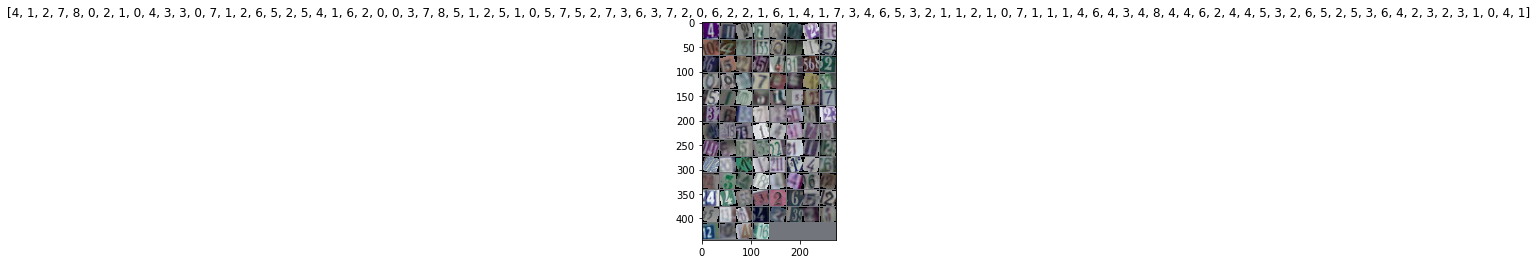

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(means)
    std = np.array(stds)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[lables_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                data = train_loader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                data = val_loader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(lables_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [0]:
device = torch.device("cuda:0")

In [11]:
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.002, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 99885603.15it/s]


Train and evaluate

^^^^^^^^^^^^^^^^^^




In [12]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8820 Acc: 0.7044
val Loss: 0.4835 Acc: 0.8461

Epoch 1/24
----------
train Loss: 0.4070 Acc: 0.8732
val Loss: 0.3504 Acc: 0.8929

Epoch 2/24
----------
train Loss: 0.3586 Acc: 0.8891
val Loss: 0.3009 Acc: 0.9073

Epoch 3/24
----------
train Loss: 0.2923 Acc: 0.9089
val Loss: 0.2771 Acc: 0.9162

Epoch 4/24
----------
train Loss: 0.2766 Acc: 0.9149
val Loss: 0.2640 Acc: 0.9210

Epoch 5/24
----------
train Loss: 0.2445 Acc: 0.9250
val Loss: 0.2504 Acc: 0.9274

Epoch 6/24
----------
train Loss: 0.2010 Acc: 0.9389
val Loss: 0.2346 Acc: 0.9335

Epoch 7/24
----------
train Loss: 0.1910 Acc: 0.9413
val Loss: 0.2346 Acc: 0.9330

Epoch 8/24
----------
train Loss: 0.1849 Acc: 0.9442
val Loss: 0.2391 Acc: 0.9309

Epoch 9/24
----------
train Loss: 0.1806 Acc: 0.9448
val Loss: 0.2359 Acc: 0.9320

Epoch 10/24
----------
train Loss: 0.1746 Acc: 0.9473
val Loss: 0.2333 Acc: 0.9337

Epoch 11/24
----------
train Loss: 0.1724 Acc: 0.9479
val Loss: 0.2338 Acc: 0.9333

Ep

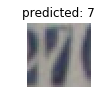

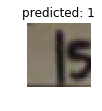

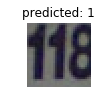

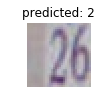

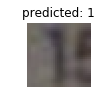

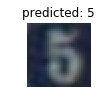

In [13]:
visualize_model(model_ft)